# Predicting Critical Violations of Health Code: Dining in Las Vegas
                                        By Mikhail Gorshunov
Restaurants are frequent settings for foodborne illness outbreaks. Periodic inspection of restaurants is crucial to ensure commercial food establishments carry out safe food handling procedures. Predictive analytics can help identify problematic restaurants and maximize the utility of limited enforcement resources. In this project, I attempt to develop a machine learning model that predicts restaurants and other dining venues likely to face health code challenges in Las Vegas. The original data can be obtained using the [City of Las Vegas Open Data Portal](https://opendataportal-lasvegas.opendata.arcgis.com/datasets/restaurant-inspections-open-data/explore).

In [1]:
#import Python libraries
import pandas as pd
pd.set_option('display.max_rows', None, 'display.max_columns', None, 'display.width', None)
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#read in the dataset into dataframe and display first three rows
df = pd.read_csv('TRAIN_SET_2021.csv')
df.head(3)

,RESTAURANT_SERIAL_NUMBER,RESTAURANT_PERMIT_NUMBER,RESTAURANT_NAME,RESTAURANT_LOCATION,RESTAURANT_CATEGORY,ADDRESS,CITY,STATE,ZIP,CURRENT_DEMERITS,CURRENT_GRADE,EMPLOYEE_COUNT,MEDIAN_EMPLOYEE_AGE,MEDIAN_EMPLOYEE_TENURE,INSPECTION_TIME,INSPECTION_TYPE,INSPECTION_DEMERITS,VIOLATIONS_RAW,RECORD_UPDATED,LAT_LONG_RAW,FIRST_VIOLATION,SECOND_VIOLATION,THIRD_VIOLATION,FIRST_VIOLATION_TYPE,SECOND_VIOLATION_TYPE,THIRD_VIOLATION_TYPE,NUMBER_OF_VIOLATIONS,NEXT_INSPECTION_GRADE_C_OR_BELOW
0,DA1117270,PR0004527,SANDS EXPO HALL B2 CONCESSION,SANDS EXPO & CONVENTION CENTER,Snack Bar,201 E Sands Ave,Las Vegas,Nevada,89169-2617,0.0,A,25.0,27.959983,13.004886,11/5/2013 16:15,Routine Inspection,11,"2,042,153,022,955",1/6/2015 16:34,"(36.1221442, 115.1652749)",204.0,215.0,302.0,Critical,Major,Imminent Health Hazard,4,0
1,DA1014948,PR0024221,THAI NOODLES CAFE - RESTAURANT,THAI NOODLES CAFE,Restaurant,6710 W CHEYENNE Ave,Las Vegas,Nevada,89108-4588,3.0,A,7.0,27.719365,3.922086,9/21/2012 13:00,Routine Inspection,9,"214,216,229,230,233",2/21/2013 22:26,"(36.218691, 115.242913)",214.0,216.0,229.0,Major,Major,Non-Major,5,0
2,DA0861994,PR0019017,SANTA FE SPORTS BOOK GRILL,Santa Fe Station Hotel & Casino,Restaurant,4949 N Rancho Dr,Las Vegas,Nevada,89130-3505,8.0,A,23.0,26.442637,10.312777,9/16/2011 11:50,Routine Inspection,9,"202,215,233",4/6/2015 9:00,"(36.2498922, 115.2441383)",202.0,215.0,233.0,Critical,Major,Non-Major,3,1


# Initial Data Exploration and Observations
I converted all uppercase characters in column names into lowercase characters to facilitate data manipulation. I also renamed the target variable to 'c_grade.'

The concise summary of the dataframe indicates that many rows have some missing values. The heat map shows that missing values do not seem to occur because of a systematic reason. As such, the missing values can be imputed without introducing a significant bias to the data.

While the dataframe contains many features, my unreported exploratory analyses indicate that most of these features are neither predictive of the target nor necessary. For instance, the information contained in 'current_grade' is already reflected in 'current_demerits.' As such, I focus my analyses on numeric features that tend to contain richer information compared to categorical data. I focus on the following six numeric features: 
- current_demerits
- employee_count
- inspection_demerits
- number_of_violations
- median_employee_age
- median_employee_tenure

In [3]:
df.columns = df.columns.str.lower()
df.rename(columns = {'next_inspection_grade_c_or_below':'c_grade'}, inplace = True) 
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15673 entries, 0 to 15672
Data columns (total 28 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   restaurant_serial_number  15673 non-null  object 
 1   restaurant_permit_number  15673 non-null  object 
 2   restaurant_name           15608 non-null  object 
 3   restaurant_location       15473 non-null  object 
 4   restaurant_category       15543 non-null  object 
 5   address                   15603 non-null  object 
 6   city                      15437 non-null  object 
 7   state                     15464 non-null  object 
 8   zip                       15614 non-null  object 
 9   current_demerits          15457 non-null  float64
 10  current_grade             15365 non-null  object 
 11  employee_count            15580 non-null  float64
 12  median_employee_age       15639 non-null  float64
 13  median_employee_tenure    15376 non-null  float64
 14  inspec

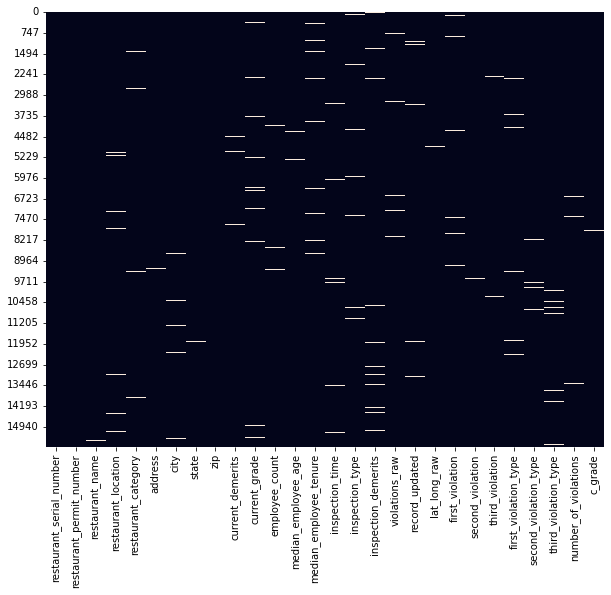

In [4]:
# create heatmap for missing values
sns.heatmap(df.isnull(), cbar=False)
plt.gcf().set_size_inches(10, 8)
plt.show()

# Cleaning Target Variable
To explore the c_grade column, I created a frequency distribution table. The table reveals that the most common values are coded 0 and 1. Additionally, the column contains 40 missings values and some erroneous entries. I slice the dataframe that contains only 0 and 1 values and convert the column to the integer type to address these issues. The resulting dataframe contains 84% of values codes 1, while the remaining 16% were coded 0.

In [5]:
# create frequency distribution table for the c_grade column
df.c_grade.value_counts(dropna=False)

0       13143
1        2484
NaN        40
-3          1
Goat        1
7           1
9           1
4           1
3           1
Name: c_grade, dtype: int64

In [6]:
#slice the df
df = df[(df.c_grade == '1') | (df.c_grade == '0')]
df.c_grade = df.c_grade.astype('int')

In [7]:
# create frequency distribution table for c_grade column after slicing df
round(df.c_grade.value_counts(normalize=True, dropna=False)*100,0)

0    84.0
1    16.0
Name: c_grade, dtype: float64

# Cleaning Features
The frequency distribution table for the current_demerits columns indicates that the columns contain missing, unusually high, float, and negative values. The column should contain only natural numbers not exceeding 87. To address this issue, I replace values outside this criterion as missing, fill missing values with a mean value, and convert the column to the integer type. I follow a similar procedure to clean the remaining five features.

In [8]:
# create frequency distribution table for current_demerits column
df.current_demerits.value_counts(dropna=False)

 0.00       3920
 3.00       3115
 8.00       2437
 6.00       2198
 9.00       1868
 5.00        763
 10.00       449
 NaN         216
 7.00        111
 19.00        73
 4.00         60
 20.00        50
 1.00         48
 2.00         35
 14.00        34
 17.00        23
 27.00        16
 11.00        16
 12.00        15
 25.00        13
 22.00        13
 32.00        13
 16.00        11
 18.00        11
 31.00        10
 30.00         9
 46.00         9
 100.00        8
 51.00         7
 13.00         7
 23.00         7
 42.00         7
 24.00         6
 35.00         6
 26.00         6
 39.00         6
 28.00         5
 15.00         5
 38.00         5
 43.00         3
 21.00         2
 37.00         1
 33.00         1
 87.00         1
 88.00         1
 98.00         1
 363.00        1
 89.00         1
 1214.00       1
-8.00          1
 48.00         1
 3.14          1
Name: current_demerits, dtype: int64

In [9]:
#cleaing current_demerits
df.current_demerits.replace([1214, 89, 88, 363, 100, 98, -8.00, 3.14] , np.nan, inplace=True )
df.current_demerits.fillna(round(df.current_demerits.mean(), 0), inplace=True)
df.current_demerits = df.current_demerits.astype('int')

#cleaning employee_count
df.employee_count.replace([687, 111447, -7, 902] , np.nan, inplace=True )
df.employee_count = df.employee_count.astype('float')
df.employee_count.fillna(round(df.employee_count.mean(), 0), inplace=True)
df.employee_count = df.employee_count.astype('int')

#cleaning inspection_demerits
df.inspection_demerits.replace('Routine Inspection', np.nan, inplace=True )
df.inspection_demerits = df.inspection_demerits.astype('float')
df.inspection_demerits.fillna(round(df.inspection_demerits.mean(), 0), inplace=True)
df.inspection_demerits = df.inspection_demerits.astype('int')

#cleaning number_of_violations
df.number_of_violations.replace('Nevada', np.nan, inplace=True )
df.number_of_violations = df.number_of_violations.astype('float')
df.number_of_violations.fillna(round(df.number_of_violations.mean(), 0), inplace=True)
df.number_of_violations = df.number_of_violations.astype('int')

#cleaning median_employee_age
df.median_employee_age.fillna(round(df.median_employee_age.mean(), 0), inplace=True)

#cleaning median_employee_tenure
df.median_employee_tenure.fillna(round(df.median_employee_tenure.mean(), 0), inplace=True)

# ML Modeling
To determine the predictive capacity of the ML model, I split the data into a training set and testing set. Given that the number of restaurants that receive a C grade or below for their evaluation (16%) is fewer than the remaining cases (84%), I use the ClusterCentroids method to better train the model to recognize the minority class cases. This method addresses data imbalance by undersampling the majority class by replacing a cluster of majority samples with the cluster centroid of a KMeans algorithm. 

I use the pipeline tool combined with GridSearchCV to assemble several steps that can be cross-validated while setting different parameters. The preprocessing step in the pipeline includes StandardScaler, which standardizes features by removing the mean and scaling to unit variance. The classifier step includes C-Support Vector Classification, Random Forrest, Logistic Regression, and Gradient Boosting classifiers.

GridSearchCV runs through all the different parameters fed into the parameter grid and produces the best combination of parameters based on a scoring metric of your choice. The recall is used as a performance metric when there is a need to identify all positive samples; that is, when it is crucial to avoid false negatives. A health code violation is a good case for this: it is vital to find all non-compliant restaurants, possibly falsely including well-maintained venues in the prediction. Thus, I use recall as an evaluation metric when ranking results.

In [10]:
#import ML libraries
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_curve, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.under_sampling import ClusterCentroids
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV

In [11]:
y = df.c_grade
X = df[['current_demerits', 'employee_count', 'median_employee_age', 
        'median_employee_tenure','inspection_demerits', 'number_of_violations']]

In [12]:
# Create the pipeline
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

# Specify the hyperparameter space
parameters = [
{'classifier': [SVC(probability=True, random_state=0)], 
 'preprocessing': [StandardScaler(), None],  
 'classifier__gamma': [0.01, 0.1, 1, 10, 100],
 'classifier__C': [0.01, 0.1, 1, 10, 100]},
    
{'classifier': [RandomForestClassifier(n_jobs=-1, random_state=0)], 
 'preprocessing': [StandardScaler(), None], 
 'classifier__criterion': ['gini', 'entropy'],
 'classifier__max_depth': [None, 2, 3, 100],
 'classifier__max_features': ['auto', 4, 5, 6],
'classifier__min_samples_leaf': [3, 4, 5],
'classifier__min_samples_split': [8, 10, 12],
'classifier__n_estimators': [100, 200, 300]},

{'classifier': [LogisticRegression(max_iter=1000)], 
 'preprocessing': [StandardScaler(), None], 
 'classifier__C': [0.01, 0.1, 1, 10, 100]},

{'classifier': [GradientBoostingClassifier(random_state=0)], 
 'preprocessing': [StandardScaler(), None],
 'classifier__learning_rate': [0.01, 0.1, 1, 10],
 'classifier__n_estimators': [100, 200, 300],
  'classifier__max_depth': [2, 3, 5]}
]

# Instantiate the GridSearchCV object
grid = GridSearchCV(pipe, param_grid=parameters, cv=5, scoring='recall')

In [13]:
# Define resampling method
method = ClusterCentroids(random_state=0)

# Create training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# Apply resampling to the training data only
X_resampled, y_resampled = method.fit_resample(X_train, y_train)

# Fit to the training set
grid_search = grid.fit(X_resampled, y_resampled)

# Get performance metrics
predicted = grid_search.predict(X_test)

# Results
The exhaustive search identified the best parameters: SVC with the regularization parameter of 0.1 and gamma parameter for non-linear hyperplanes of 0.01 in combination with StandardScaler. This model produced a recall score for problematic restaurants of 0.73. Because this test set recall score of the model is not significantly worse than the cross-validation recall score during training (0.76), the model is not likely to overfit and can be considered reliable. Unfortunetely, the model has a very low precision score of 0.15.

In [14]:
print("Best params:\n{}\n".format(grid_search.best_params_))
print("Best cross-validation score: {:.2f}".format(grid_search.best_score_))
print("Test set score: {:.2f}".format(grid_search.score(X_test, y_test)))
print("Confusion matrix:\n{}".format(confusion_matrix(y_test, predicted)))
print (classification_report(y_test, predicted))

Best params:
{'classifier': SVC(C=0.1, gamma=0.01, probability=True, random_state=0), 'classifier__C': 0.1, 'classifier__gamma': 0.01, 'preprocessing': StandardScaler()}

Best cross-validation score: 0.76
Test set score: 0.73
Confusion matrix:
[[ 669 2623]
 [ 167  448]]
              precision    recall  f1-score   support

           0       0.80      0.20      0.32      3292
           1       0.15      0.73      0.24       615

    accuracy                           0.29      3907
   macro avg       0.47      0.47      0.28      3907
weighted avg       0.70      0.29      0.31      3907



# Conclusion
The final model uses only six numeric features to predict if a restaurant receives a C grade or below during the inspection. Three predictors refer to employee characteristics; the remaining three variables describe the degree of violations. The model could identify 73% of problematic restaurants in a holdout test data set. At the same time, misclassified many compliant restaurants as non-compliant ones. It may be a good tool if the regulator wants to identify as many problematic restaurants as possible in case there are plenty of resources to inspect many compliant restaurants. 

There is plenty of room to improve the model's predictive capacity by supplementing it with additional data sources. For instance, employee characteristics in the current model had decent effect sizes. Additional descriptive information about employees, such as experience and training in safe food preparation practices, may improve the model substantially. In addition to employees' ability, motivation and incentives to practice safe food handling (or cut corners to maximize lower quality output in the kitchen) are also essential components that may explain and predict (in)compliance by restaurants. Other projects were able to leverage social media in predicting outcomes of health inspections. For instance, Uppoor et al. used data from Yelp reviews ([see PDF](https://cseweb.ucsd.edu/classes/wi15/cse255-a/reports/fa15/036.pdf)). However, the authors reported that it is more challenging to predict critical violations than minor problems.